In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

gpu = True
if gpu:
    import sigkernel as ksig
else:
    import sigkernel_cpu as ksig

# Setup parameters and kernel choice

In [2]:
num_permutations = 10000
n_levels = 4
n_samples = 100
sample_len = 60
difference = True

static_kernel = ksig.static.kernels.LinearKernel()
# static_kernel = ksig.static.kernels.RBFKernel(lengthscale=0.5)
# static_kernel = ksig.static.kernels.PolynomialKernel(degree=1)

# Load Data

In [3]:
def plot_spx_vix(df):
    _, ax = plt.subplots(figsize=(16,9))
    df[['SPX']].plot(ax=ax, label='SPX')
    ax2 = df[['VIX']].plot(ax=ax, label='VIX', secondary_y=True, alpha=0.5)
    ax.legend(labels=['SPX'], loc='upper left')
    ax2.legend(labels=['VIX'], loc='upper right')

def generate_samples(data, n_samples, sample_len, shuffle=True):
    if len(data) < n_samples*sample_len:
        raise ValueError("data length is less than n_samples*sample_len")

    samples = []
    for i in range(n_samples):
        start = i*sample_len
        end = start + sample_len
        sample = data[start:end]
        samples.append(sample)
    samples = np.array(samples)

    if shuffle:
        np.random.shuffle(samples)

    print(f'Generated {n_samples} samples of length {sample_len} with remaining length {len(data) - n_samples*sample_len} unused')
    return samples

Generated 100 samples of length 60 with remaining length 215 unused


(100, 60, 2)

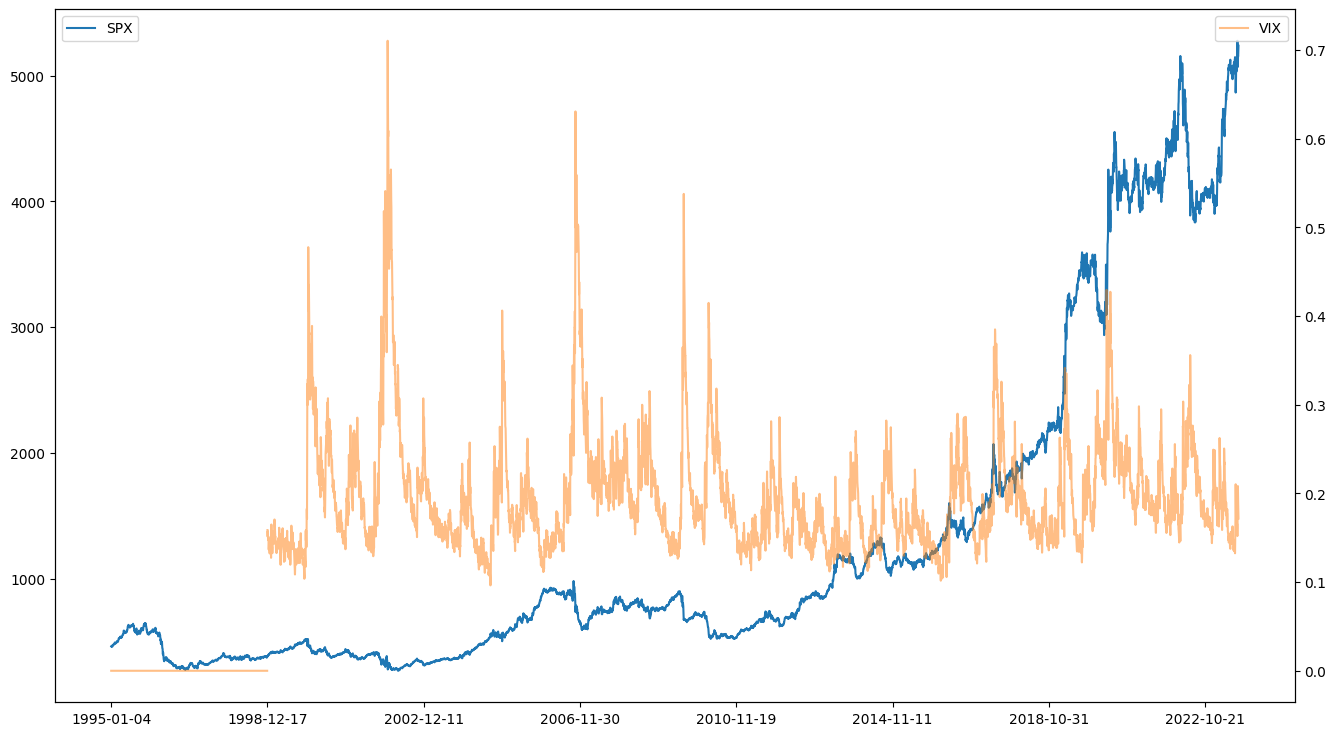

In [4]:
Y = pd.read_csv('data/sim_df_v1.csv', index_col=0)
plot_spx_vix(Y)
Y = Y['1998-12-17':].values
Y = generate_samples(Y, n_samples, sample_len, shuffle=False)
Y.shape

Generated 100 samples of length 60 with remaining length 215 unused


(100, 60, 2)

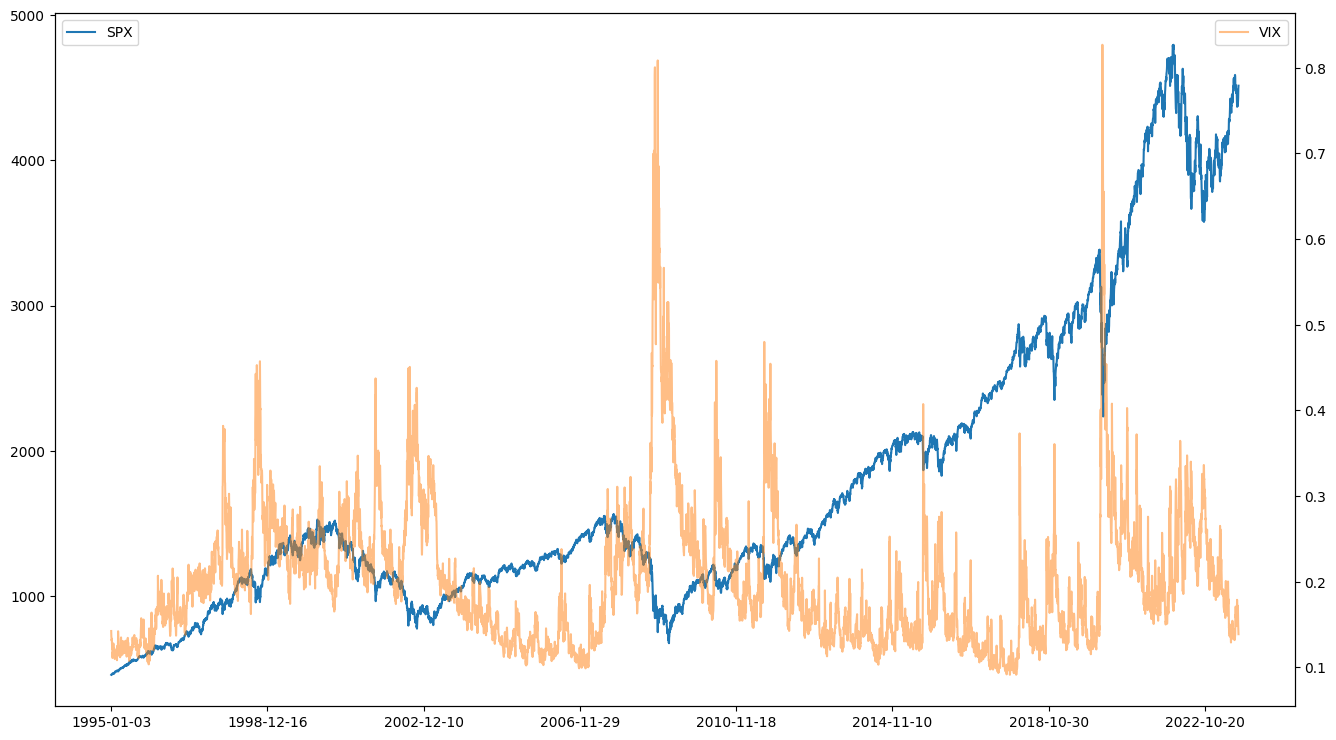

In [5]:
X = pd.read_csv('data/spx_vix_df.csv', index_col=0)
plot_spx_vix(X)
X = X['1998-12-17':].values
X = generate_samples(X, n_samples, sample_len, shuffle=True)
X.shape

In [6]:
X.shape, Y.shape

((100, 60, 2), (100, 60, 2))

# MMD Two Sample Test

### Permutation Test

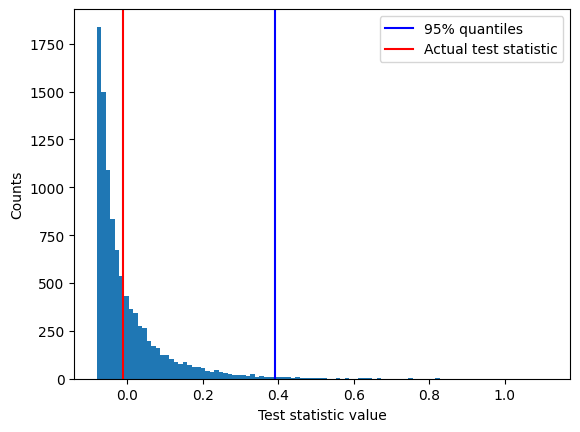

In [7]:
mmd_XY, null_mmd = ksig.tests.sig_kernel_test(X, Y, n_levels=n_levels, static_kernel=static_kernel, num_permutations=num_permutations)
ksig.tests.plot_permutation_samples(null_mmd, mmd_XY)

### MMD value against varying the ratio of mix of sample X and Y

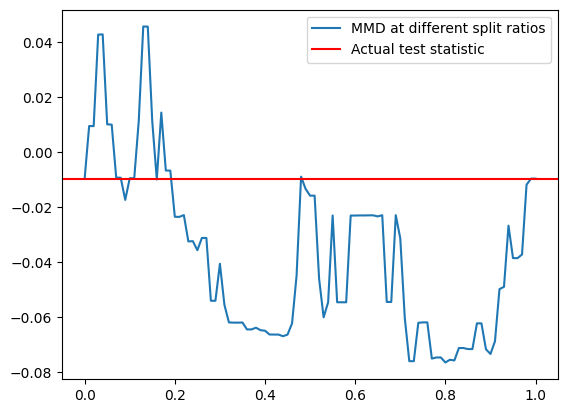

In [8]:
ksig.tests.mmd_permutation_ratio_plot(X, Y, n_levels, static_kernel, n_steps=100)

### Log of X and Y

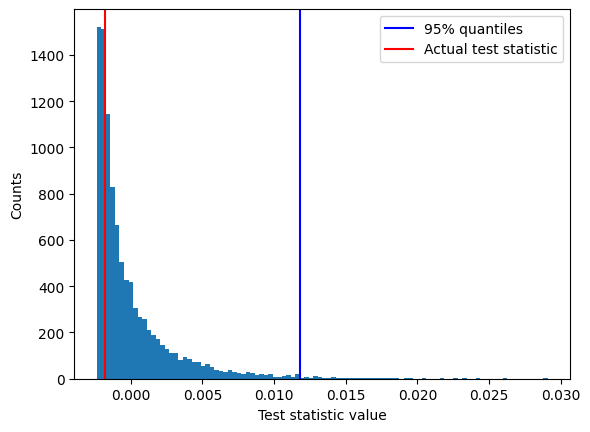

In [9]:
mmd_XY, null_mmd = ksig.tests.sig_kernel_test(np.log(X), np.log(Y), n_levels=n_levels, static_kernel=static_kernel, num_permutations=num_permutations)
ksig.tests.plot_permutation_samples(null_mmd, mmd_XY)

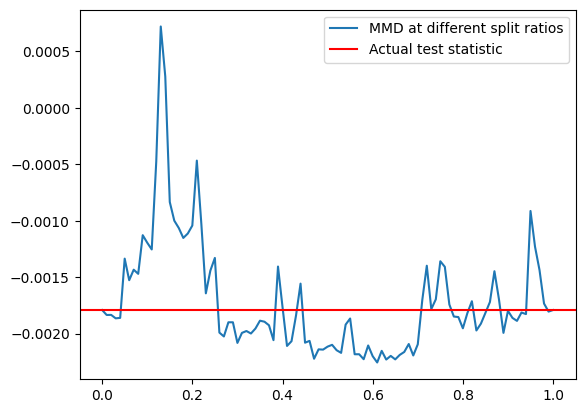

In [10]:
ksig.tests.mmd_permutation_ratio_plot(np.log(X), np.log(Y), n_levels, static_kernel, n_steps=100)

# Multiple runs

In [11]:
def savefig(path):
    plt.savefig(path)
    plt.clf()
    plt.close()

def plot_and_save_paths(path, X, Y):
    _, ax = plt.subplots(1, 2, figsize=(16, 12))
    ax[0].plot(X.squeeze().T, alpha=0.5);
    ax[1].plot(Y.squeeze().T, alpha=0.5);
    ylim = min(ax[0].get_ylim()[0], ax[1].get_ylim()[0]), max(ax[0].get_ylim()[1], ax[1].get_ylim()[1]);
    ax[0].set_ylim(ylim)
    ax[1].set_ylim(ylim)
    savefig(path)

def mmd_test_and_plot(X, Y, n_levels, static_kernel, kernel_name, log=False):
    log = '_log' if log else ''
    mmd_XY, null_mmd = ksig.tests.sig_kernel_test(X, Y, n_levels=n_levels, static_kernel=static_kernel, num_permutations=num_permutations)
    ksig.tests.plot_permutation_samples(null_mmd, mmd_XY)
    savefig(f'./figures/quantile{log}_{kernel_name}_level_{n_levels}.png')
    ksig.tests.mmd_permutation_ratio_plot(X, Y, n_levels, static_kernel, n_steps=10)
    savefig(f'./figures/splits/ratio{log}_{kernel_name}_level_{n_levels}.png')

In [ ]:
sub_size = 10
kernel_name = ['linear', 'rbf']

log_X = np.log(X)
log_Y = np.log(Y)
for j, static_kernel in enumerate([ksig.static.kernels.LinearKernel(), ksig.static.kernels.RBFKernel(lengthscale=0.2)]):
    for n_levels in range(2, 6):
        mmd_test_and_plot(X, Y, n_levels, static_kernel, kernel_name[j])
        mmd_test_and_plot(log_X, log_Y, n_levels, static_kernel, kernel_name[j], log=True)